# Opracowanie modelu regresji do przewidzenia liczby pasażerów transportu kolejowego
#### Autorzy: Szymon Kowalski, Zuzanna Czyżowska - zespół 18
## 1. Wprowadzenie

W poprzedniej części projektu, przeprowadziliśmy analizę naszego zbioru i na jej podstawie dokonaliśmy doboru cech do naszego modelu. Cechy zapisaliśmy do nowego pliku .csv, aby szybko przejść do opracowania modelu regresji.

## 2. Importy i załadowanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_validate, validation_curve, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
tables = pd.read_csv('all_data_after_analyze.csv')

print("Dane:")
print(tables.head())
print("Rozmiar danych:")
print(tables.shape)

Dane:
    n        year  country     pa_tr  pa_tr_na  pa_tr_in     tr_tr  \
0  18  2013-01-01  Austria  235434.0  225063.0   10371.0  134386.0   
1  11  2013-01-01  Croatia   24216.0   23810.0     406.0   16651.0   
2   3  2013-01-01  Czechia  174189.0  170790.0    3399.0  127109.0   
3   4  2013-01-01  Denmark  193500.0  181151.0   12349.0   67045.0   
4   6  2013-01-01  Estonia    4199.0    4077.0     122.0    3337.0   

       le_ra_tr  le_li_hi  le_li_up_hi  ...  n_lo_di  n_ra_di  n_lo_el  ca_ve  \
0   9708.000000       0.0        237.0  ...    464.0    226.0    888.0  269.0   
1   4090.000000       0.0          0.0  ...    159.0    106.0    107.0   33.0   
2  15607.000000       0.0          0.0  ...   1126.0    737.0    770.0  288.0   
3   3613.330147       0.0          0.0  ...     89.0   1088.0     36.0  141.0   
4   2146.000000       0.0          0.0  ...    293.0     46.0      0.0   24.1   

     ex_in    in_in          po  co_pr_le   le_mo    n_pa_air  
0  319.000  211.000   

### Opis zbioru:
Każda obserwacja występuje dla danego europejskiego kraju  w danym roku (od 2013 do 2023). W zbiorze widać, że jest 35 kolumn i 330 obserwacji:
- n - numer obserwacji,
- year - rok obserwacji (dane są zbierane na stan 1 stycznia danego roku)
- country - kraj

Nasza kolumna-klasa (jednostki w nawiasach):
- pa_tr - przewiezieni pasażerowie (tys.)

Pozostałe kolumny to cechy, których wpływ na naszą klasę będziemy sprawdzać i możemy podzielić je na kategorie:

a) Transport kolejowy
- pa_tr_na - przewiezieni pasażerowie w transporcie krajowym (tys.)
- pa_tr_in - przewiezieni pasażerowie w transporcie międzynarodowym (tys.)
- tr_tr - praca przewozowa pociągów (tys. pociągokm-ile pociągów przebyło 1 km)

b) Infrastruktura kolejowa:
- le_ra_tr - długość torów kolejowych (km)
- le_li_hi - długość dedykowanych linii kolei dużych prędkości (powyżej 250 km/h) (km)
- le_li_up_hi - długość zmodernizowanych linii kolei dużych prędkości (200-250 km/h) (km)

c) Sprzęt
- n_co_tr - liczba wagonów (liczba)
- n_lo_di - liczba lokomotyw spalinowych (liczba)
- n_ra_di - liczba szynobusów spalinowych (liczba)
- n_lo_el - liczba lokomotyw elektrycznych (liczba)
- ca_ve - pojemność pasażerskich pojazdów kolejowych (tys. miejsc)

d) Stan demograficzny i ekonomiczny w danym kraju
- po - populacja kraju (liczba)
- co_pr_le - porównawcze poziomy cen w danym kraju (wskaźnik poziomu cen, UE-27 = 100) - ta cecha ma na celu pokazanie, czy dany kraj jest droższy lub tańszy w porównaniu do średniej unijnej, poniżej 100 - jest tańszy, powyżej 100 - droższy

e) Wydatki i inwestycje
- ex_in - wydatki na infrastrukturę (mln euro) - utrzymanie, konserwacja, naprawy itp.
- in_in - inwestycje w infrastrukturę (mln euro)

f) Konkurencja
- le_mo - długość autostrad (km)
- n_pa_air - liczba pasażerów na pokładzie samolotów (odloty i przyloty w danym kraju) (liczba pasażerów)

## 3. Dobór cech i przygotowanie zbiorów

### 1. Cechy o najwyższej korelacji z cechą określaną

Cechy o najwyższej korelacji z 'pa_tr':
pa_tr          1.000000
ex_in          0.937190
le_ra_tr       0.867369
ca_ve          0.849487
n_co_tr        0.847892
in_in          0.845658
n_ra_di        0.816365
tr_tr          0.764917
n_pa_air       0.764773
po             0.750645
le_mo          0.697490
n_lo_el        0.661338
n_lo_di        0.653437
le_li_hi       0.435849
le_li_up_hi    0.351197
co_pr_le       0.254780
Name: pa_tr, dtype: float64


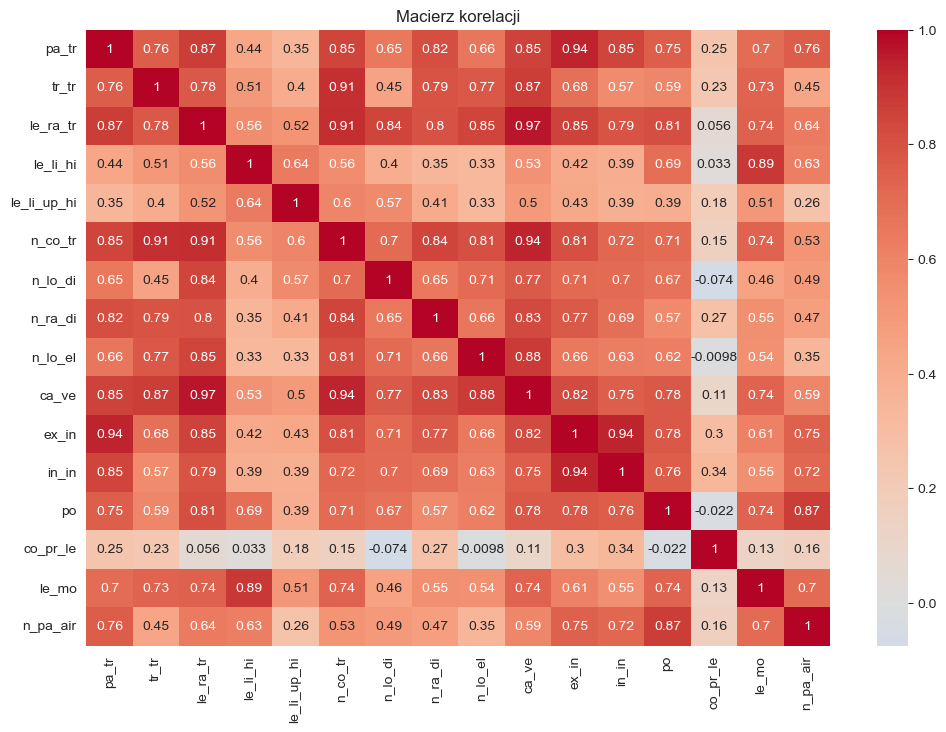

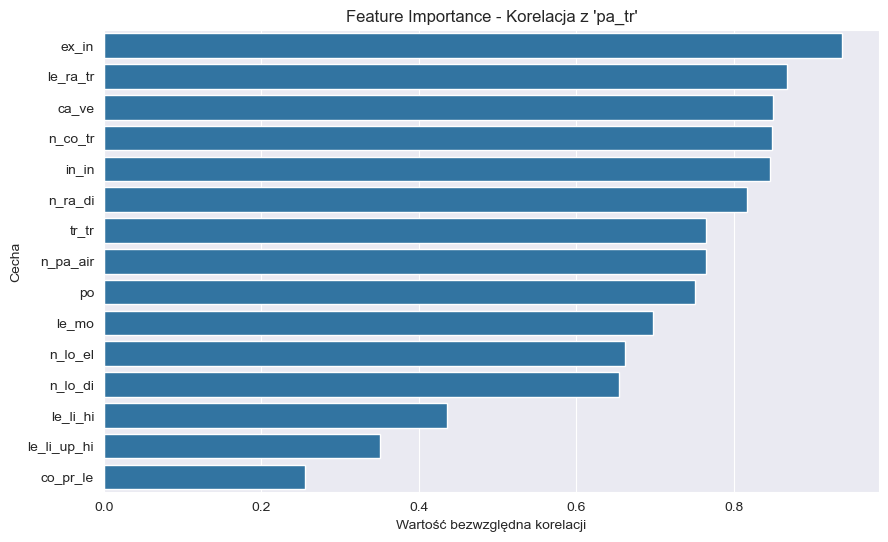

In [3]:
tables_drop_col = tables.drop(columns=['n', 'country', 'year','pa_tr_na', 'pa_tr_in'])
correlation_matrix = tables_drop_col.corr()

# Korelacja z celem (pa_tr)
target_correlation = correlation_matrix['pa_tr'].sort_values(ascending=False)

# Wyświetlenie cech o najwyższej korelacji
print("Cechy o najwyższej korelacji z 'pa_tr':")
print(target_correlation)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Macierz korelacji")
plt.show()

# Korelacja z celem (pa_tr)
target_correlation_abs = target_correlation.drop('pa_tr').abs().sort_values(ascending=False)

# DataFrame z wartościami korelacji
correlation_features = pd.DataFrame({
    'Feature': target_correlation_abs.index,
    'Correlation': target_correlation_abs.values
})

# Wizualizacja
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Feature', data=correlation_features)
plt.title("Feature Importance - Korelacja z 'pa_tr'")
plt.xlabel("Wartość bezwzględna korelacji")
plt.ylabel("Cecha")
plt.show()

Wydatki na infrastrukturę (ex_in), długość torów kolejowych (le_ra_tr), liczba wagonów (n_co_tr) oraz pojemność pojazdów kolejowych (ca_ve) wykazują najwyższą dodatnią korelację z liczbą pasażerów kolei. To potwierdza, że rozwój infrastruktury i taboru bezpośrednio przekłada się na większy ruch pasażerski.

### 2. Podzielenie zbioru na uczący i testowy

In [4]:
X = tables_drop_col.drop(['pa_tr'], axis=1)
y = tables_drop_col['pa_tr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Rozmiar zbioru treningowego:", X_train.shape, "\nRozmiar zbioru testowego:", X_test.shape)

Rozmiar zbioru treningowego: (228, 15) 
Rozmiar zbioru testowego: (58, 15)


### 3. Metoda drzew losowych

Ważność cech według Random Forest:
        Feature  Importance
9         ex_in    0.758599
13        le_mo    0.099252
6       n_ra_di    0.042247
10        in_in    0.028361
8         ca_ve    0.015749
0         tr_tr    0.009518
1      le_ra_tr    0.007923
12     co_pr_le    0.007386
11           po    0.007320
4       n_co_tr    0.006718
3   le_li_up_hi    0.004366
5       n_lo_di    0.003950
2      le_li_hi    0.003406
14     n_pa_air    0.003322
7       n_lo_el    0.001882


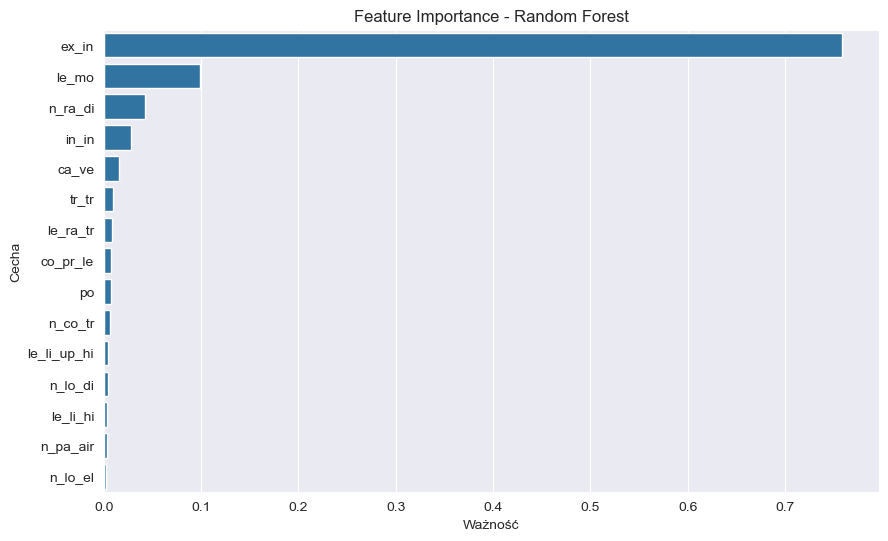

In [5]:
# Model Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Ważność cech
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Ważność cech według Random Forest:")
print(feature_importances)

# Wizualizacja
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Ważność")
plt.ylabel("Cecha")
plt.show()

Najważniejszą cechą są wydatki na infrastrukturę (ex_in), które znacznie przewyższają inne pod względem ważności. Znaczenie długości autostrad (le_mo) oraz liczby szynobusów spalinowych (n_ra_di) wskazuje na istotny wpływ transportu konkurencyjnego i regionalnego.

### 4. Metoda Lasso

Najpierw znajdziemy alpha, dla którego RMSE jest najmniejsze.

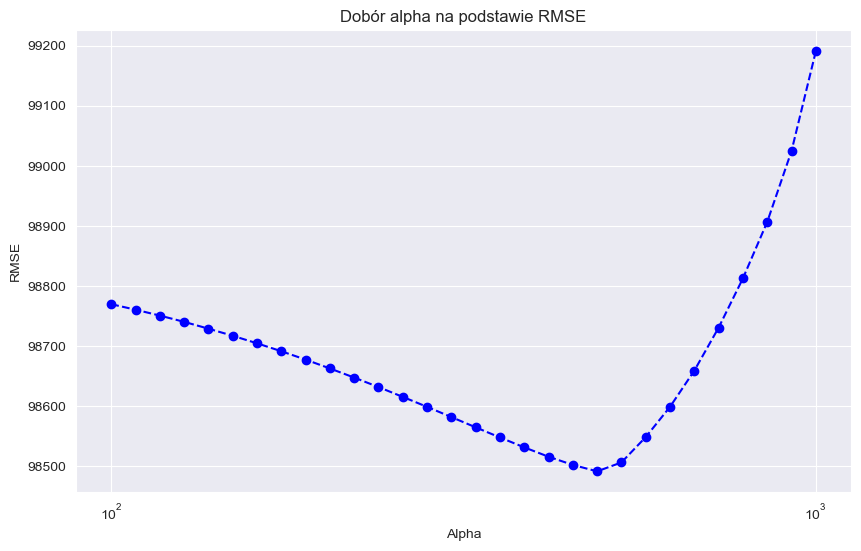

Najlepsze alpha na podstawie RMSE: 489.3900918477494


In [6]:
# Skalowanie cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista wartości alpha (logarytmicznie rozłożone)
alphas = np.logspace(2, 3, 30)

results = []

for alpha in alphas:

    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'Alpha': alpha, 'RMSE': rmse})

results_df = pd.DataFrame(results)

# Wizualizacja wyników
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['Alpha'], results_df['RMSE'], marker='o', linestyle='--', color='b')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Dobór alpha na podstawie RMSE')
plt.xscale('log')
plt.show()

# Wybranie najlepszej wartości alpha (najmniejszy RMSE)
best_alpha = results_df.loc[results_df['RMSE'].idxmin(), 'Alpha']
print("Najlepsze alpha na podstawie RMSE:", best_alpha)

Współczynniki cech dla najlepszego modelu LASSO (posortowane według wartości bezwzględnej):
        Feature    Coefficient
14     n_pa_air  252107.383033
9         ex_in  232962.664135
2      le_li_hi -229834.914080
4       n_co_tr  217435.462649
13        le_mo  195596.837303
1      le_ra_tr  147306.860077
11           po -133587.629157
8         ca_ve  -99435.582316
6       n_ra_di   52788.438284
10        in_in  -41971.324301
7       n_lo_el  -37918.783725
3   le_li_up_hi  -20062.120334
12     co_pr_le  -15055.352615
0         tr_tr    7430.806574
5       n_lo_di     349.091640


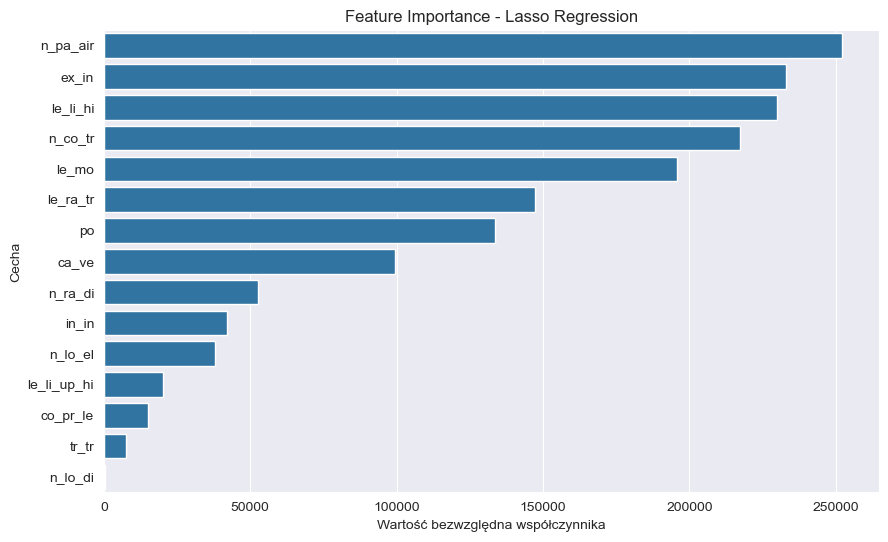

In [7]:
# Finalny model z najlepszym alpha
final_lasso = Lasso(alpha=best_alpha, random_state=42)
final_lasso.fit(X_train_scaled, y_train)

# Wyświetlenie współczynników cech posortowanych po wartości bezwzględnej
print("Współczynniki cech dla najlepszego modelu LASSO (posortowane według wartości bezwzględnej):")
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': final_lasso.coef_,
    'Absolute Coefficient': np.abs(final_lasso.coef_)
}).sort_values(by='Absolute Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']])

# Wizualizacja współczynników Lasso
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute Coefficient', y='Feature', data=coefficients)
plt.title("Feature Importance - Lasso Regression")
plt.xlabel("Wartość bezwzględna współczynnika")
plt.ylabel("Cecha")
plt.show()

Oprócz wydatków na infrastrukturę (ex_in), istotny wpływ mają liczba pasażerów lotniczych (n_pa_air) i długość torów kolejowych (le_ra_tr). Negatywny wpływ długości linii dużych prędkości (le_li_hi) oraz pojemności pojazdów kolejowych (ca_ve) sugeruje, że nadmiarowa lub niedostosowana infrastruktura może nie zawsze odpowiadać rzeczywistym potrzebom pasażerów.

### 4. Utworzenie zbiorów danych na podstawie ważności cech

Na podstawie R² Score sprawdzamy, dla jakich progów powstaną najlepsze zestawy cech dla każdej metody

In [8]:
def evaluate_r2(X_features, y):
    model = LinearRegression()
    scores = cross_val_score(model, X_features, y, cv=5, scoring='r2')
    return scores.mean()

best_results = {}

# 1. Korelacja
correlation_thresholds = np.arange(0.5, 0.95, 0.05)  # Progi od 0.5 do 0.9
best_r2_corr, best_thresh_corr = -np.inf, 0

for thresh in correlation_thresholds:
    selected_features = target_correlation[target_correlation > thresh].index.difference(['pa_tr'])
    X_corr = tables_drop_col[selected_features]

    if not X_corr.empty:
        r2 = evaluate_r2(X_corr, y)
        if r2 > best_r2_corr:
            best_r2_corr, best_thresh_corr = r2, thresh

best_results['Korelacja'] = (best_thresh_corr, best_r2_corr)


# 2. Random Forest
importance_thresholds = np.arange(0.005, 0.05, 0.005)  # Progi od 0.005 do 0.05
best_r2_rf, best_thresh_rf = -np.inf, 0

for thresh in importance_thresholds:
    selected_features = feature_importances[feature_importances['Importance'] > thresh]['Feature']
    X_rf = tables_drop_col[selected_features]

    if not X_rf.empty:
        r2 = evaluate_r2(X_rf, y)
        if r2 > best_r2_rf:
            best_r2_rf, best_thresh_rf = r2, thresh

best_results['Random Forest'] = (best_thresh_rf, best_r2_rf)


# 3. Lasso
lasso_multipliers = np.arange(0.5, 2.0, 0.25)  # Progi od 0.5 do 2 * mediany
best_r2_lasso, best_thresh_lasso = -np.inf, 0
median_coefficient = coefficients['Coefficient'].abs().median()

for multiplier in lasso_multipliers:
    thresh = median_coefficient * multiplier
    selected_features = coefficients.loc[coefficients['Coefficient'].abs() > thresh, 'Feature']
    X_lasso = tables_drop_col[selected_features]

    if not X_lasso.empty:
        r2 = evaluate_r2(X_lasso, y)
        if r2 > best_r2_lasso:
            best_r2_lasso, best_thresh_lasso = r2, thresh

best_results['Lasso'] = (best_thresh_lasso, best_r2_lasso)


# Wyświetlenie najlepszych progów i wyników R²
for method, (threshold, r2) in best_results.items():
    print(f"{method}: Najlepszy próg = {threshold:.4f}, R² = {r2:.4f}")

Korelacja: Najlepszy próg = 0.5000, R² = 0.9534
Random Forest: Najlepszy próg = 0.0200, R² = 0.8984
Lasso: Najlepszy próg = 74576.6867, R² = 0.9643


In [9]:
# Z korelacji
high_correlation_features = target_correlation[target_correlation > best_thresh_corr].index.difference(['pa_tr'])
print(high_correlation_features)
X_corr = tables_drop_col[high_correlation_features]

# Drzewa losowe
high_importance_features = feature_importances[feature_importances['Importance'] > best_thresh_rf]['Feature']
print(high_importance_features)
X_rf = tables_drop_col[high_importance_features]

# Lasso
high_coefficient_features = coefficients.loc[coefficients['Coefficient'].abs() > best_thresh_lasso, 'Feature']
print(high_coefficient_features)
X_lasso = tables_drop_col[high_coefficient_features]

Index(['ca_ve', 'ex_in', 'in_in', 'le_mo', 'le_ra_tr', 'n_co_tr', 'n_lo_di',
       'n_lo_el', 'n_pa_air', 'n_ra_di', 'po', 'tr_tr'],
      dtype='object')
9       ex_in
13      le_mo
6     n_ra_di
10      in_in
Name: Feature, dtype: object
14    n_pa_air
9        ex_in
2     le_li_hi
4      n_co_tr
13       le_mo
1     le_ra_tr
11          po
8        ca_ve
Name: Feature, dtype: object


## 4. Modelowanie regresji

In [10]:
# Ogólna funkcja do wyznaczenia modelu regresji wielorakiej
def regresja_wieloraka(X_train, X_test, y_train, y_test):
    #Model regresji liniowej
    model_linear = LinearRegression()
    model_linear.fit(X_train, y_train)

    y_pred_test = model_linear.predict(X_test)
    y_pred_train = model_linear.predict(X_train)

    mae = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2 = r2_score(y_test, y_pred)

    return mae, mse_test, mse_train, r2

In [11]:
# Ogólna funkcja do wyznaczania modelu regresji wielorakiej z zastosowaniem walidacji krzyżowej KFold
def regresja_wieloraka_cv(X, y, cv=5):
    model_linear = LinearRegression()
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Walidacja krzyżowa z obliczeniem R2 i RMSE
    scores = cross_validate(
        model_linear,
        X,
        y,
        cv=kfold,
        scoring=['r2', 'neg_mean_squared_error'],  # Możemy obliczyć R² i negatywne MSE
        return_train_score=True
    )

    # Średnia dokładność (R²)
    mean_r2 = np.mean(scores['test_r2'])

    # Obliczenie błędu testowego i treningowego (RMSE)
    mse_test_cv = scores['test_neg_mean_squared_error']
    mse_train_cv = scores['train_neg_mean_squared_error']

    rmse_test_cv = np.mean(np.sqrt(np.abs(mse_test_cv)))
    rmse_train_cv = np.mean(np.sqrt(np.abs(mse_train_cv)))

    return mean_r2, rmse_train_cv, rmse_test_cv

Do określenia skuteczności danych modeli użyjemy wyznaczonych przez powyższe funkcje parametrów MAE, RMSE, NRMSE i R² score. Głównie skupimy się jednak na RMSE i R² score, dążąc do tego, aby RMSE (Root Mean Squared Error) treningowe i testowe były jak najmniejsze, ale również jak najbardziej zbliżone do siebie. R² score pozwoli nam ocenić, jaką dokładność ma model. Porównanie wartości błędu uczenia i błędu testowego pokażą nam, jak model dopasowuje się do nowych danych i czy nie jest przeuczony. Pokazujemy też wartości NRMSE (Normalized Root Mean Squared Error), żeby zobaczyć, jak duży jest błąd predykcji w stosunku do skali danych.

### 1. Regresja wieloraka ze wszystkimi cechami

In [12]:
# Podział na zbiór uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae, mse_test, mse_train, r2_all = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error_all = np.sqrt(mse_train)
test_error_all = np.sqrt(mse_test)
print("Wyniki ewaluacji modelu regresji wielorakiej ze wszystkimi cechami:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Błąd uczenia (RMSE): {train_error_all:.4f}")
print(f"Błąd testowy (RMSE: {test_error_all:.4f})")
print(f"R² Score: {r2_all:.4f}")

nrmse_train_all = train_error_all / np.mean(y_train)
nrmse_test_all = test_error_all / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train_all:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {nrmse_test_all:.4f}")

Wyniki ewaluacji modelu regresji wielorakiej ze wszystkimi cechami:
Mean Absolute Error (MAE): 71469.1987
Błąd uczenia (RMSE): 86701.0494
Błąd testowy (RMSE: 98884.3254)
R² Score: 0.9829
Normalizowany błąd uczący (NRMSE): 0.2873
Normalizowany błąd testowy (NRMSE): 0.2201


In [13]:
# Porównanie dla walidacji krzyżowej
cv_r2_all, rmse_train_cv_all, rmse_test_cv_all = regresja_wieloraka_cv(X, y, cv=5)

print(f'Błąd uczenia (RMSE): {rmse_train_cv_all:.4f}')
print(f'Błąd testowy (RMSE): {rmse_test_cv_all:.4f}')
print(f'Średnia dokładność (R² Score): {cv_r2_all:.4f}')

cv_nrmse_train_all = rmse_train_cv_all / np.mean(y)
cv_nrmse_test_all = rmse_test_cv_all / np.mean(y)

print(f"Normalizowany błąd uczący (NRMSE): {cv_nrmse_train_all:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {cv_nrmse_test_all:.4f}")

Błąd uczenia (RMSE): 86893.7121
Błąd testowy (RMSE): 99505.9791
Średnia dokładność (R² Score): 0.9550
Normalizowany błąd uczący (NRMSE): 0.2620
Normalizowany błąd testowy (NRMSE): 0.3000


### 2. Regresja wieloraka z cechami z korelacji

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_corr, y, test_size=0.2, random_state=42)

mae_corr, mse_test_corr, mse_train_corr, r2_corr = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error_corr = np.sqrt(mse_train_corr)
test_error_corr = np.sqrt(mse_test_corr)

print("Wyniki ewaluacji modelu regresji wielorakiej z cechami z korelacji:")
print(f"Mean Absolute Error (MAE): {mae_corr:.4f}")
print(f"Błąd uczenia (RMSE): {train_error_corr:.4f}")
print(f"Błąd testowy (RMSE): {test_error_corr:.4f}")
print(f"R² Score: {r2_corr:.4f}")

nrmse_train_corr = train_error_corr / np.mean(y_train)
nrmse_test_corr = test_error_corr / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train_corr:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {nrmse_test_corr:.4f}")

Wyniki ewaluacji modelu regresji wielorakiej z cechami z korelacji:
Mean Absolute Error (MAE): 71469.1987
Błąd uczenia (RMSE): 116930.8424
Błąd testowy (RMSE): 120265.6225
R² Score: 0.9829
Normalizowany błąd uczący (NRMSE): 0.3875
Normalizowany błąd testowy (NRMSE): 0.2677


In [15]:
# Porównanie dla walidacji krzyżowej
cv_r2_corr, rmse_train_cv_corr, rmse_test_cv_corr = regresja_wieloraka_cv(X_corr, y, cv=5)

print(f'Błąd uczenia (RMSE): {rmse_train_cv_corr:.4f}')
print(f'Błąd testowy (RMSE): {rmse_test_cv_corr:.4f}')
print(f'Średnia dokładność (R² Score): {cv_r2_corr:.4f}')

cv_nrmse_train_corr = rmse_train_cv_corr / np.mean(y)
cv_nrmse_test_corr = rmse_test_cv_corr / np.mean(y)

print(f"Normalizowany błąd uczący (NRMSE): {cv_nrmse_train_corr:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {cv_nrmse_test_corr:.4f}")

Błąd uczenia (RMSE): 115629.5972
Błąd testowy (RMSE): 125515.3540
Średnia dokładność (R² Score): 0.9221
Normalizowany błąd uczący (NRMSE): 0.3486
Normalizowany błąd testowy (NRMSE): 0.3784


### 3. Regresja wieloraka z cechami z drzew losowych

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42)

mae_rf, mse_test_rf, mse_train_rf, r2_rf = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error_rf = np.sqrt(mse_train_rf)
test_error_rf = np.sqrt(mse_test_rf)

print("Wyniki ewaluacji modelu regresji wielorakiej z cechami z drzew losowych:")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"Błąd uczenia (RMSE): {train_error_rf:.4f}")
print(f"Błąd testowy (RMSE): {test_error_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

nrmse_train_rf = train_error_rf / np.mean(y_train)
nrmse_test_rf = test_error_rf / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train_rf:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {nrmse_test_rf:.4f}")

Wyniki ewaluacji modelu regresji wielorakiej z cechami z drzew losowych:
Mean Absolute Error (MAE): 71469.1987
Błąd uczenia (RMSE): 163158.1984
Błąd testowy (RMSE): 181662.8042
R² Score: 0.9829
Normalizowany błąd uczący (NRMSE): 0.5407
Normalizowany błąd testowy (NRMSE): 0.4043


In [17]:
# Porównanie dla walidacji krzyżowej
cv_r2_rf, rmse_train_cv_rf, rmse_test_cv_rf = regresja_wieloraka_cv(X_rf, y, cv=5)

print(f'Błąd uczenia (RMSE): {rmse_train_cv_rf:.4f}')
print(f'Błąd testowy (RMSE): {rmse_test_cv_rf:.4f}')
print(f'Średnia dokładność (R² Score): {cv_r2_rf:.4f}')

cv_nrmse_train_rf = rmse_train_cv_rf / np.mean(y)
cv_nrmse_test_rf = rmse_test_cv_rf / np.mean(y)

print(f"Normalizowany błąd uczący (NRMSE): {cv_nrmse_train_rf:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {cv_nrmse_test_rf:.4f}")

Błąd uczenia (RMSE): 164364.1810
Błąd testowy (RMSE): 172154.5953
Średnia dokładność (R² Score): 0.8802
Normalizowany błąd uczący (NRMSE): 0.4955
Normalizowany błąd testowy (NRMSE): 0.5190


### 4. Regresja wieloraka z cechami z metody Lasso

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=42)

mae_lasso, mse_test_lasso, mse_train_lasso, r2_lasso = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error_lasso = np.sqrt(mse_train_lasso)
test_error_lasso = np.sqrt(mse_test_lasso)

print("Wyniki ewaluacji modelu regresji wielorakiej z cechami z metody Lasso:")
print(f"Mean Absolute Error (MAE): {mae_lasso:.4f}")
print(f"Błąd uczenia (RMSE): {train_error_lasso:.4f}")
print(f"Błąd testowy (RMSE): {test_error_lasso:.4f}")
print(f"R² Score: {r2_lasso:.4f}")

nrmse_train_lasso = train_error_lasso / np.mean(y_train)
nrmse_test_lasso = test_error_lasso / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train_lasso:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {nrmse_test_lasso:.4f}")

Wyniki ewaluacji modelu regresji wielorakiej z cechami z metody Lasso:
Mean Absolute Error (MAE): 71469.1987
Błąd uczenia (RMSE): 97467.7002
Błąd testowy (RMSE): 112042.6580
R² Score: 0.9829
Normalizowany błąd uczący (NRMSE): 0.3230
Normalizowany błąd testowy (NRMSE): 0.2494


In [19]:
# Porównanie dla walidacji krzyżowej
cv_r2_lasso, rmse_train_cv_lasso, rmse_test_cv_lasso = regresja_wieloraka_cv(X_lasso, y, cv=5)

print(f'Błąd uczenia (RMSE): {rmse_train_cv_lasso:.4f}')
print(f'Błąd testowy (RMSE): {rmse_test_cv_lasso:.4f}')
print(f'Średnia dokładność (R² Score): {cv_r2_lasso:.4f}')

cv_nrmse_train_lasso = rmse_train_cv_lasso / np.mean(y)
cv_nrmse_test_lasso = rmse_test_cv_lasso / np.mean(y)

print(f"Normalizowany błąd uczący (NRMSE): {cv_nrmse_train_lasso:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {cv_nrmse_test_lasso:.4f}")

Błąd uczenia (RMSE): 99657.5905
Błąd testowy (RMSE): 102548.4511
Średnia dokładność (R² Score): 0.9501
Normalizowany błąd uczący (NRMSE): 0.3005
Normalizowany błąd testowy (NRMSE): 0.3092


### 5. Wizualizacja wyników i ocena modeli

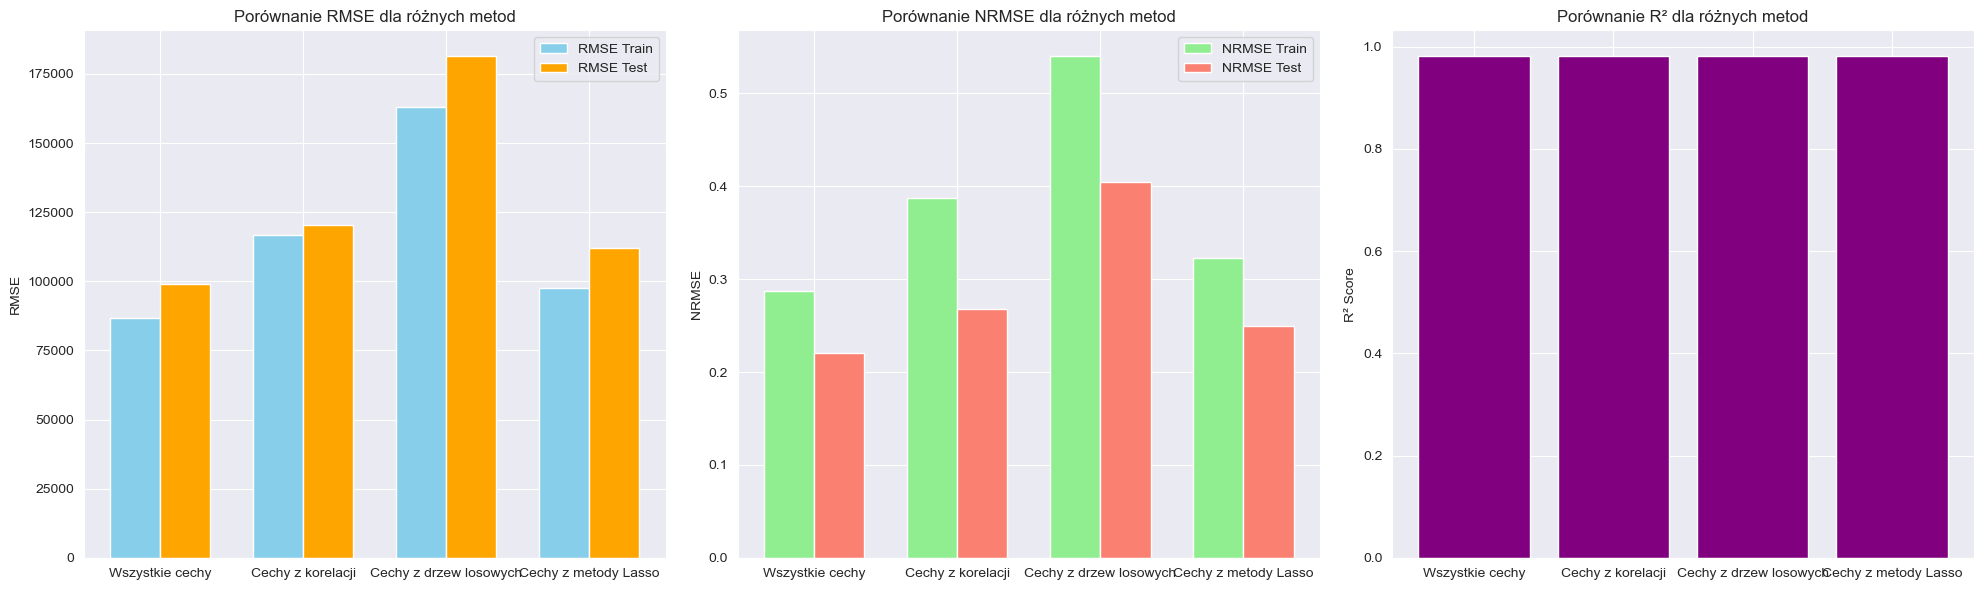

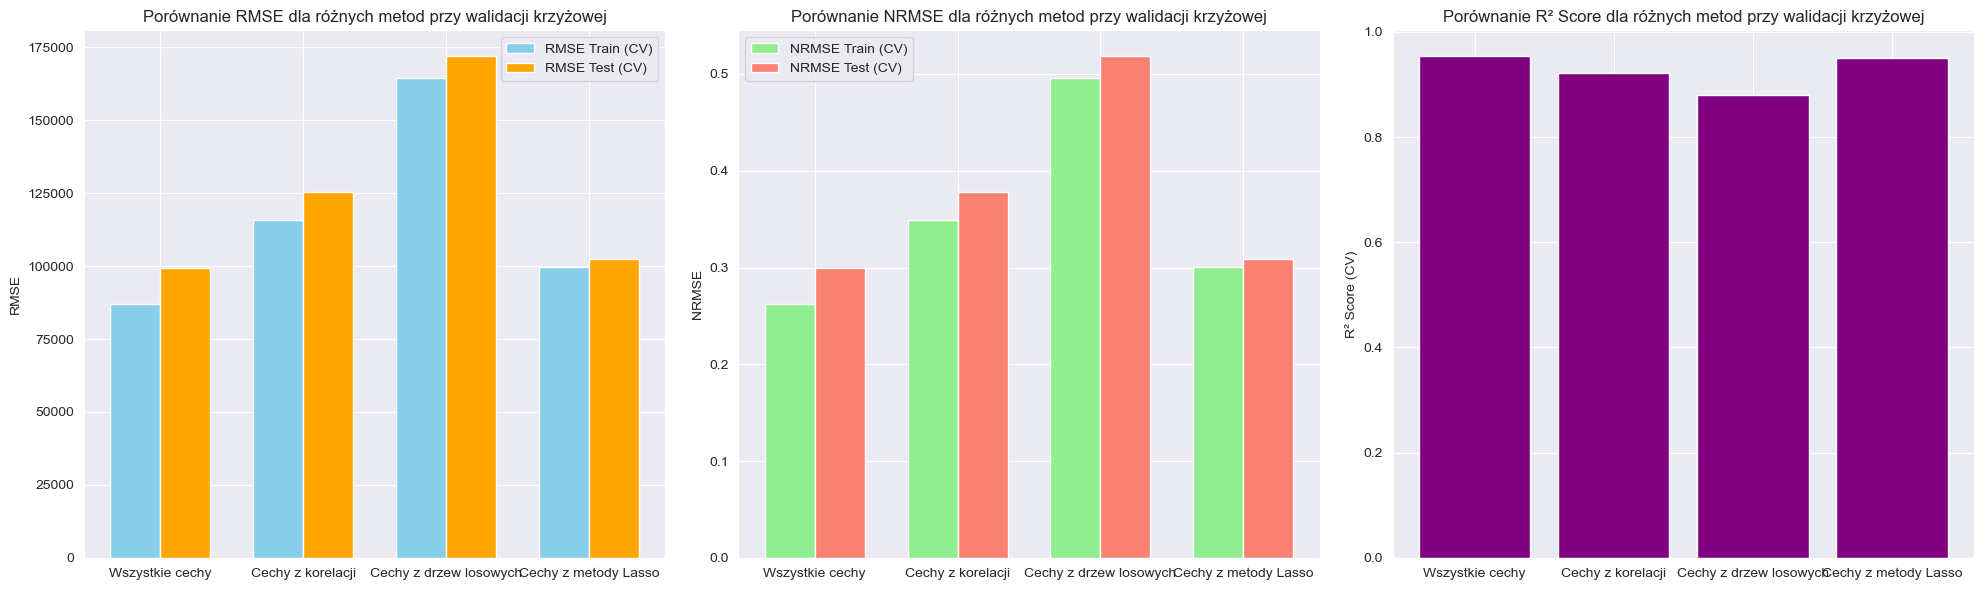

In [20]:
methods = ['Wszystkie cechy','Cechy z korelacji', 'Cechy z drzew losowych', 'Cechy z metody Lasso']
rmse_train = [train_error_all, train_error_corr, train_error_rf, train_error_lasso]
rmse_test = [test_error_all, test_error_corr, test_error_rf, test_error_lasso]
nrmse_train = [nrmse_train_all, nrmse_train_corr, nrmse_train_rf, nrmse_train_lasso]
nrmse_test = [nrmse_test_all, nrmse_test_corr, nrmse_test_rf, nrmse_test_lasso]
r2_scores = [r2_all, r2_corr, r2_rf, r2_lasso]

cv_rmse_train = [rmse_train_cv_all, rmse_train_cv_corr, rmse_train_cv_rf, rmse_train_cv_lasso]
cv_rmse_test = [rmse_test_cv_all, rmse_test_cv_corr, rmse_test_cv_rf, rmse_test_cv_lasso]
cv_nrmse_train = [cv_nrmse_train_all, cv_nrmse_train_corr, cv_nrmse_train_rf, cv_nrmse_train_lasso]
cv_nrmse_test = [cv_nrmse_test_all, cv_nrmse_test_corr, cv_nrmse_test_rf, cv_nrmse_test_lasso]
cv_r2_scores = [cv_r2_all.mean(), cv_r2_corr.mean(), cv_r2_rf.mean(), cv_r2_lasso.mean()]

# Wizualizacja RMSE
plt.figure(figsize=(20, 6))

# Wizualizacja RMSE train i test
plt.subplot(1, 3, 1)
x = np.arange(len(methods))
width = 0.35
plt.bar(x - width / 2, rmse_train, width, label='RMSE Train', color='skyblue')
plt.bar(x + width / 2, rmse_test, width, label='RMSE Test', color='orange')
plt.xticks(x, methods)
plt.ylabel('RMSE')
plt.title('Porównanie RMSE dla różnych metod')
plt.legend()

# Wizualizacja NRMSE
plt.subplot(1, 3, 2)
plt.bar(x - width / 2, nrmse_train, width, label='NRMSE Train', color='lightgreen')
plt.bar(x + width / 2, nrmse_test, width, label='NRMSE Test', color='salmon')
plt.xticks(x, methods)
plt.ylabel('NRMSE')
plt.title('Porównanie NRMSE dla różnych metod')
plt.legend()

# Wizualizacja R² Score
plt.subplot(1, 3, 3)
plt.bar(methods, r2_scores, color='purple')
plt.ylabel('R² Score')
plt.title('Porównanie R² dla różnych metod')

plt.tight_layout()
plt.show()

# Wizualizacja RMSE train i test dla walidacji krzyżowej
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
x = np.arange(len(methods))
width = 0.35
plt.bar(x - width / 2, cv_rmse_train, width, label='RMSE Train (CV)', color='skyblue')
plt.bar(x + width / 2, cv_rmse_test, width, label='RMSE Test (CV)', color='orange')
plt.xticks(x, methods)
plt.ylabel('RMSE')
plt.title('Porównanie RMSE dla różnych metod przy walidacji krzyżowej')
plt.legend()

# Wizualizacja NRMSE
plt.subplot(1, 3, 2)
plt.bar(x - width / 2, cv_nrmse_train, width, label='NRMSE Train (CV)', color='lightgreen')
plt.bar(x + width / 2, cv_nrmse_test, width, label='NRMSE Test (CV)', color='salmon')
plt.xticks(x, methods)
plt.ylabel('NRMSE')
plt.title('Porównanie NRMSE dla różnych metod przy walidacji krzyżowej')
plt.legend()

# Wizualizacja CV R² score
plt.subplot(1, 3, 3)
plt.bar(methods, cv_r2_scores, color='purple')
plt.ylabel('R² Score (CV)')
plt.title('Porównanie R² Score dla różnych metod przy walidacji krzyżowej')

plt.tight_layout()
plt.show()


Na podstawie otrzymanych wyników z wybranych przez nas metod doboru cech można wywnioskować, że przy trenowaniu na zbiorze utworzonym dzięki metodzie Lasso i przy zastosowaniu walidacji krzyżowej powstał najlepszy model regresji, ponieważ charakteryzuje się on w miarę niskim błędem średniokwadratowym, ale co ważniejsze błąd treningowy i testowy w tym przypadku były najbardziej do siebie zbliżone. W innych przypadkach, mimo że nie były to duże różnice, to błąd treningowy miał wyraźnie niższe wartości od błędu testowego, co mogło wskazywać na przeuczenie modelu. Dlatego model regresji dla zbioru powstałego dzięki metodzie Lasso daje nam najbardziej zrównoważony model, który najlepiej reaguje na nowe dane.

## 4. Regularyzacja modelu

Przeprowadziliśmy regularyzację dla najlepszego modelu z poprzedniej części (zbiór utworzony dzięki metodzie Lasso), ale wyniki przed i po były praktycznie identyczne, dlatego postanowiliśmy przeprowadzić regularyzację dla drugiego najlepszego modelu, (w tym wypadku ten gdzie w zbiorze danych były wszystkie cechy) w celu porównania wyników.

### 1. Implementacja regresji Ridge

Szukanie najlepszego alpha.

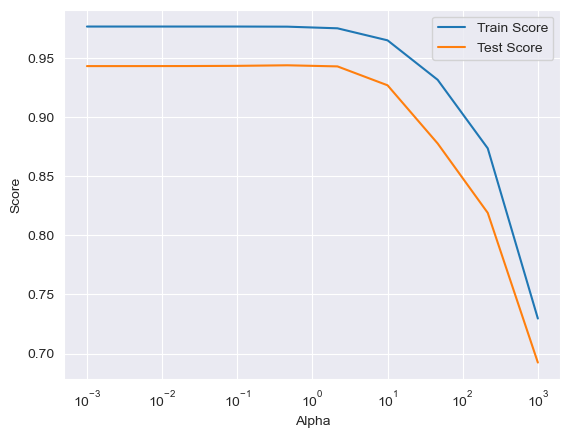

Najlepsza wartość alpha: 0.4642


In [21]:
#Standaryzacja cech
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

param_range = np.logspace(-3, 3, 10)
train_scores, test_scores = validation_curve(
    Ridge(), X_train_scaled, y_train, param_name="alpha", param_range=param_range, cv=5
)

plt.plot(param_range, train_scores.mean(axis=1), label="Train Score")
plt.plot(param_range, test_scores.mean(axis=1), label="Test Score")
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.show()

best_alpha_index = np.argmax(test_scores.mean(axis=1))  # Indeks najlepszego alpha na podstawie wyników testowych
best_alpha = param_range[best_alpha_index]
print(f'Najlepsza wartość alpha: {best_alpha:.4f}')

In [22]:
#Model Ridge Regression
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train_scaled, y_train)

# Prognozy na zbiorze testowym
y_pred_scaled = model_ridge.predict(X_test_scaled)
y_pred_train = model_ridge.predict(X_train_scaled)

# Obliczenie metryk
mae = mean_absolute_error(y_test, y_pred_scaled)
mse_test = mean_squared_error(y_test, y_pred_scaled)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_test, y_pred_scaled)

# Wyświetlenie wyników
print("Wyniki ewaluacji modelu regresji Ridge ze wszystkimi cechami:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Błąd treningowy: {rmse_train:.4f}")
print(f"Błąd testowy: {rmse_test:.4f}")
print(f"R² Score: {r2:.4f}")

nrmse_train = rmse_train / np.mean(y_train)
nrmse_test = rmse_test / np.mean(y_test)

print(f"Znormalizowany błąd uczący (NRMSE): {nrmse_train:.4f}")
print(f"Znormalizowany błąd testowy (NRMSE): {nrmse_test:.4f}")

# Wagi cech w modelu
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_ridge.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

Wyniki ewaluacji modelu regresji Ridge ze wszystkimi cechami:
Mean Absolute Error (MAE): 71014.6790
Błąd treningowy: 86808.3172
Błąd testowy: 98754.8814
R² Score: 0.9830
Znormalizowany błąd uczący (NRMSE): 0.2877
Znormalizowany błąd testowy (NRMSE): 0.2198
        Feature    Coefficient
14     n_pa_air  249948.033430
9         ex_in  233453.761540
4       n_co_tr  210635.959420
13        le_mo  195873.469265
1      le_ra_tr  157732.938019
6       n_ra_di   51128.296797
0         tr_tr   22744.458479
5       n_lo_di    9104.828667
12     co_pr_le  -14709.269138
3   le_li_up_hi  -21934.387238
10        in_in  -43456.344286
7       n_lo_el  -43742.718934
8         ca_ve -115450.486156
11           po -131242.533987
2      le_li_hi -231099.619943


In [23]:
# Porównanie z walidacją krzyżową
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    Ridge(alpha=best_alpha),
    X_scaled,
    y,
    cv=kfold,
    scoring=['r2', 'neg_mean_squared_error'],
    return_train_score=True
)

# Średnia dokładność (R²)
mean_r2_cv = np.mean(cv_results['test_r2'])

# Obliczenie błędu testowego i treningowego (RMSE)
mse_test_cv = cv_results['test_neg_mean_squared_error']
mse_train_cv = cv_results['train_neg_mean_squared_error']

rmse_test_cv = np.mean(np.sqrt(np.abs(mse_test_cv)))
rmse_train_cv = np.mean(np.sqrt(np.abs(mse_train_cv)))

nrmse_train_cv = rmse_train_cv / np.mean(y)
nrmse_test_cv = rmse_test_cv / np.mean(y)

print(f"Średni RMSE - trening: {rmse_train_cv:.4f}")
print(f"Średni RMSE - test: {rmse_test_cv:.4f}")
print(f"Znormalizowany błąd uczący (NRMSE): {nrmse_train_cv:.4f}")
print(f"Znormalizowany błąd testowy (NRMSE): {nrmse_test_cv:.4f}")
print(f"Średni R² Score: {mean_r2_cv:.4f}")

Średni RMSE - trening: 87021.2574
Średni RMSE - test: 99021.0019
Znormalizowany błąd uczący (NRMSE): 0.2624
Znormalizowany błąd testowy (NRMSE): 0.2985
Średni R² Score: 0.9554


### 2. Wizualizacja i ocena wyników oraz porównanie przed i po regularyzacji

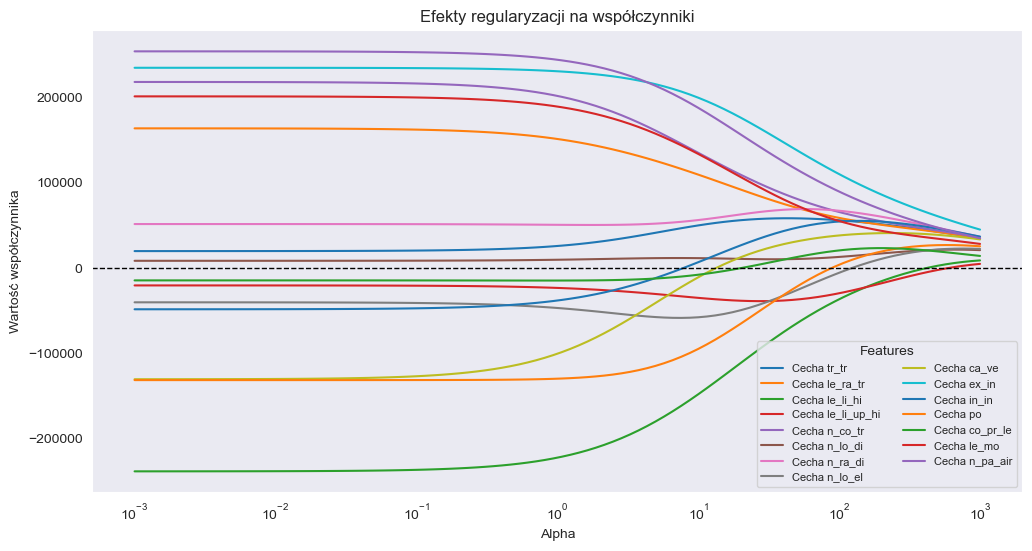

In [24]:
alphas = np.logspace(-3, 3, 100)
coefs = []

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
    
coefs = np.array(coefs)
plt.figure(figsize=(12, 6))

for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f'Cecha {X.columns[i]}')

plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Wartość współczynnika")
plt.title("Efekty regularyzacji na współczynniki")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.legend(loc="best", fontsize=8, title="Features", ncol=2)
plt.grid()
plt.show()

In [25]:
print("Przed regularyzacją (dobór Lasso):")
print(f'Błąd uczenia (RMSE): {rmse_train_cv_lasso:.4f}')
print(f'Błąd testowy (RMSE): {rmse_test_cv_lasso:.4f}')
print(f"Normalizowany błąd uczący (NRMSE): {cv_nrmse_train_lasso:.4f}")
print(f"Normalizowany błąd testowy (NRMSE): {cv_nrmse_test_lasso:.4f}")
print(f'Średnia dokładność (R² Score): {cv_r2_lasso:.4f}')

print("\nPo regularyzacji (wszystkie cechy, regularyzacja Ridge):")
print(f"Średni RMSE - trening: {rmse_train_cv:.4f}")
print(f"Średni RMSE - test: {rmse_test_cv:.4f}")
print(f"Znormalizowany błąd uczący (NRMSE): {nrmse_train_cv:.4f}")
print(f"Znormalizowany błąd testowy (NRMSE): {nrmse_test_cv:.4f}")
print(f"Średni R² Score: {mean_r2_cv:.4f}")

Przed regularyzacją (dobór Lasso):
Błąd uczenia (RMSE): 99657.5905
Błąd testowy (RMSE): 102548.4511
Normalizowany błąd uczący (NRMSE): 0.3005
Normalizowany błąd testowy (NRMSE): 0.3092
Średnia dokładność (R² Score): 0.9501

Po regularyzacji (wszystkie cechy, regularyzacja Ridge):
Średni RMSE - trening: 87021.2574
Średni RMSE - test: 99021.0019
Znormalizowany błąd uczący (NRMSE): 0.2624
Znormalizowany błąd testowy (NRMSE): 0.2985
Średni R² Score: 0.9554


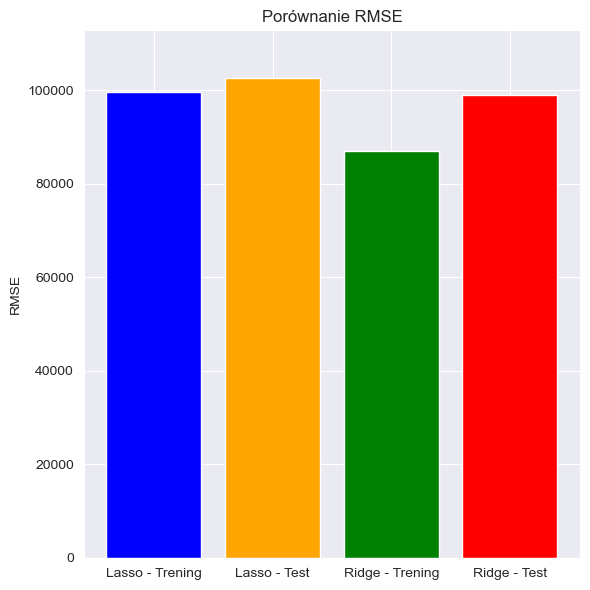

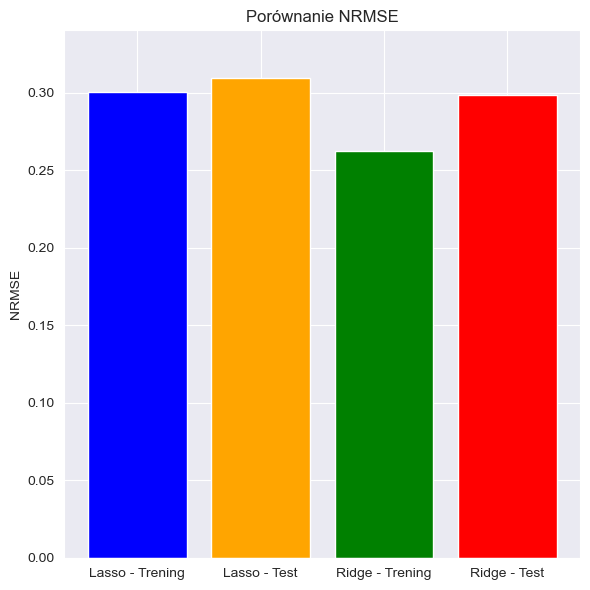

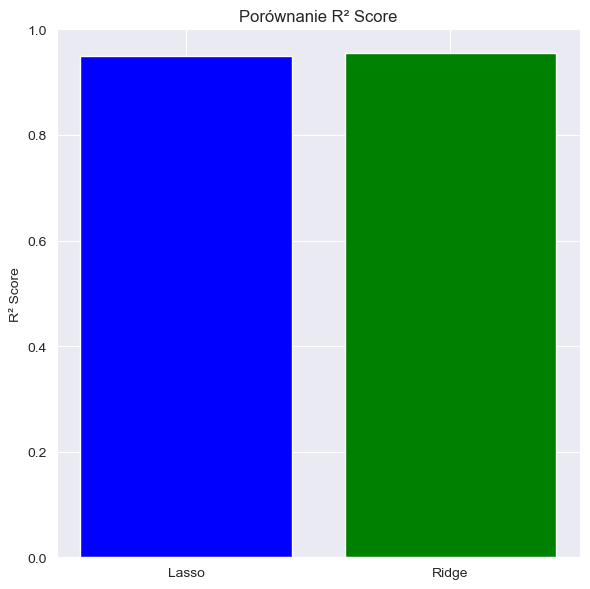

In [26]:
plt.figure(figsize=(6, 6))
plt.bar(['Lasso - Trening', 'Lasso - Test', 'Ridge - Trening', 'Ridge - Test'],
        [rmse_train_cv_lasso, rmse_test_cv_lasso, rmse_train_cv, rmse_test_cv],
        color=['blue', 'orange', 'green', 'red'])
plt.title('Porównanie RMSE')
plt.ylabel('RMSE')
plt.ylim([0, max(rmse_train_cv_lasso, rmse_test_cv_lasso, rmse_train_cv, rmse_test_cv) * 1.1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.bar(['Lasso - Trening', 'Lasso - Test', 'Ridge - Trening', 'Ridge - Test'],
        [cv_nrmse_train_lasso, cv_nrmse_test_lasso, nrmse_train_cv, nrmse_test_cv],
        color=['blue', 'orange', 'green', 'red'])
plt.title('Porównanie NRMSE')
plt.ylabel('NRMSE')
plt.ylim([0, max(cv_nrmse_train_lasso, cv_nrmse_test_lasso, nrmse_train_cv, nrmse_test_cv) * 1.1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.bar(['Lasso', 'Ridge'], [cv_r2_lasso, mean_r2_cv], color=['blue', 'green'])
plt.title('Porównanie R² Score')
plt.ylabel('R² Score')
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

## 5. Wnioski
Regularyzacja Ridge zmniejszyła błąd średniokwadratowy dla modelu ze wszystkimi cechami, ale nadal błędy treningowy i testowy nie są do siebie tak zbliżone, jak w przypadku wybranego przez nas modelu powstałego dzięki metodzie Lasso. Model z regularyzacji, patrząc po wynikach, mógł zostać przeuczony. Dokładność ma nieznacznie większą od modelu ze zbioru Lasso, ale naszym celem było doprowadzenie do powstania najbardziej stabilnego modelu. Dlatego model nauczony na zbiorze z cechami wybranymi metodą Lasso okazał się najlepszym modelem dla całego badanego przez nas w tym projekcie zbioru.

## 6. Raport końcowy

Celem projektu było stworzenie modelu regresji do przewidywania liczby pasażerów transportu kolejowego w państwach europejskich na podstawie wybranych cech dostępnych w zbiorze danych. Cechy te obejmowały między innymi infrastrukturę kolejową, liczbę pojazdów kolejowych, sytuację ekonomiczną w kraju oraz wielkość inwestycji w transport kolejowy.

Proces analizy obejmował przygotowanie danych, które wymagało usunięcia mało znaczących cech i niekompletnych obserwacji, a także imputacji braków danych różnymi metodami (m.in. `bfill` i `ffill`). W kolejnych krokach określono korelacje między cechami i dokonano selekcji tych, które miały największy wpływ na liczbę pasażerów. Jednocześnie eliminowano cechy silnie ze sobą skorelowane, pozostawiając jedną z nich w zbiorze.

Spośród niemal 30 pierwotnych cech udało się wyodrębnić 17 najważniejszych, na podstawie których przeprowadzono modelowanie. Ostateczny zbiór danych zawierał 286 obserwacji, co pozwoliło na efektywną naukę modelu regresji. W trakcie analizy część cech i obserwacji została wyeliminowana ze względu na ich niską istotność dla modelu, silne korelacje z innymi zmiennymi lub zbyt duże braki danych, dla których imputacja nie była możliwa.

Większość hipotez postawionych na początku projektu została potwierdzona. Rozwój infrastruktury oraz liczba i pojemność taboru kolejowego okazały się kluczowe dla liczby pasażerów. Populacja danego kraju również miała znaczący wpływ na wynik modelu. Natomiast inwestycje i wydatki na infrastrukturę miały większy wpływ, niż się spodziewano. Zaskakująco niski był natomiast wpływ wskaźników ekonomicznych, takich jak PKB czy inflacja, które okazały się niemal niezależne od liczby pasażerów kolei. Również długość linii dużych prędkości (`le_li_hi`) miała niewielką korelację z liczbą pasażerów, co może wynikać z faktu, że w Europie nadal występuje niewiele takich linii, a ich dostępność jest ograniczona. Interesującym odkryciem była pozytywna zależność pomiędzy rozwojem konkurencyjnych środków transportu a liczbą pasażerów kolei. Choć początkowo zakładano, że rozwój autostrad i lotnisk będzie negatywnie wpływał na transport kolejowy, analiza wykazała, że wzrost inwestycji w te środki transportu często idzie w parze z rozwojem kolei, co może być wynikiem wspólnych inwestycji infrastrukturalnych. Na przykład jednym z głównych środków transportu na lotniska są właśnie pociągi.

Finalnie otrzymany zbiór danych umożliwił naukę modeli regresji, które przewidują roczną liczbę pasażerów transportu kolejowego w poszczególnych krajach Europy.

W projekcie zastosowano trzy różne metody doboru cech: analizę korelacji, drzewa losowe oraz metodę Lasso. W wyniku tych metod powstały różne zbiory cech, które różniły się zarówno licznością, jak i dokładnością modeli. Modele zostały przetestowane zarówno na standardowym podziale na zbiory treningowe i testowe, jak i przy użyciu walidacji krzyżowej. Wyniki metryk RMSE, NRMSE oraz \(R^2\) pozwoliły na porównanie skuteczności poszczególnych modeli.

Okazało się, że najlepsze wyniki osiągnął model wytrenowany na zbiorze cech wybranych metodą Lasso. Na drugim miejscu uplasował się model wykorzystujący wszystkie cechy, co było pewnym zaskoczeniem. Modele oparte na korelacji i drzewach losowych osiągnęły gorsze wyniki, przy czym model oparty na drzewach losowych charakteryzował się największymi błędami średniokwadratowymi, największą różnicą między błędem treningowym i testowym oraz najniższą stabilnością. W przypadku wyboru między modelem Lasso a modelem z wszystkimi cechami, decyzja zależała od tego, czy priorytetem jest mniejsza wartość błędu treningowego i testowego, czy ich wyrównanie.

Najważniejsze cechy wpływające na liczbę pasażerów kolei, uszeregowane według istotności i wartości wag w modelu Lasso, to:
1. Liczba pasażerów lotniczych (`n_pa_air`) – 252107.383033
2. Wydatki na infrastrukturę (`ex_in`) – 232962.664135
3. Długość linii dużych prędkości (`le_li_hi`) – -229834.914080
4. Liczba wagonów (`n_co_tr`) – 217435.462649
5. Długość autostrad (`le_mo`) – 195596.837303
6. Długość torów (`le_ra_tr`) – 147306.860077
7. Populacja (`po`) – -133587.629157
8. Pojemność pojazdów kolejowych (`ca_ve`) – -99435.582316

Cechy takie jak liczba pasażerów lotniczych i wydatki na infrastrukturę miały największy pozytywny wpływ na liczbę pasażerów transportu kolejowego, co podkreśla znaczenie inwestycji w transport. Z kolei negatywne wagi dla długości linii dużych prędkości i pojemności pojazdów mogą sugerować nadmiarowość infrastruktury lub jej niedostosowanie do rzeczywistych potrzeb pasażerów.

Nie spodziewaliśmy się, że rozwój konkurencyjnych środków transportu będzie miał tak pozytywny i znaczący wpływ na liczbę pasażerów kolei. Zaskoczeniem było również to, że pojemność wagonów okazała się mieć negatywny wpływ na naszą zmienną zależną, co może wynikać z nadmiarowej pojemności taboru w stosunku do rzeczywistych potrzeb pasażerów. Zgodnie z naszymi przewidywaniami, wydatki na infrastrukturę, długość torów oraz liczba wagonów miały jednak duże, pozytywne znaczenie dla liczby pasażerów kolei.

Finalnie wybrany model regresji oparty na metodzie Lasso okazał się najbardziej efektywny i stabilny, a więc mógłby służyć do przewidywania liczby pasażerów kolei w Europie.